# imports

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

# Configurations

In [20]:
RANDOM_SEED = 42
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
MODEL_NAME = "bert-base-cased"

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Loading Data


In [21]:
df = pd.read_csv("/content/reviews.csv")

def to_sentiment(score):
    score = int(score)
    if score <= 2:
        return 0
    elif score == 3:
        return 1
    else:
        return 2

df["sentiment"] = df.score.apply(to_sentiment)

class_names = ["negative", "neutral", "positive"]

In [22]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo,0
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo,0
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo,0
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo,0
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo,0


# Data Overview

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12495 non-null  object
 1   userName              12495 non-null  object
 2   userImage             12495 non-null  object
 3   content               12495 non-null  object
 4   score                 12495 non-null  int64 
 5   thumbsUpCount         12495 non-null  int64 
 6   reviewCreatedVersion  10333 non-null  object
 7   at                    12495 non-null  object
 8   replyContent          5818 non-null   object
 9   repliedAt             5818 non-null   object
 10  sortOrder             12495 non-null  object
 11  appId                 12495 non-null  object
 12  sentiment             12495 non-null  int64 
dtypes: int64(3), object(10)
memory usage: 1.2+ MB


In [24]:
df.describe()

,score,thumbsUpCount,sentiment
count,12495.000000,12495.000000,12495.000000
mean,3.094198,3.047459,1.064346
std,1.457693,14.303903,0.914649
min,1.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000
50%,3.000000,0.000000,1.000000
75%,4.000000,1.000000,2.000000
max,5.000000,397.000000,2.000000


# Classical ML (TF-IDF)

In [25]:
X = df["content"]
y = df["sentiment"]

vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y, test_size=0.25, random_state=RANDOM_SEED
)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=500, max_depth=7),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Gradient Boosting": GradientBoostingClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name}")
    print(classification_report(y_test, preds))
    print ("-----------------------------------------")


Random Forest
              precision    recall  f1-score   support

           0       0.67      0.39      0.49      1198
           1       0.00      0.00      0.00       521
           2       0.54      0.93      0.69      1405

    accuracy                           0.57      3124
   macro avg       0.40      0.44      0.39      3124
weighted avg       0.50      0.57      0.50      3124

-----------------------------------------

Decision Tree
              precision    recall  f1-score   support

           0       0.63      0.36      0.46      1198
           1       0.00      0.00      0.00       521
           2       0.53      0.92      0.67      1405

    accuracy                           0.55      3124
   macro avg       0.39      0.43      0.38      3124
weighted avg       0.48      0.55      0.48      3124

-----------------------------------------

Gradient Boosting
              precision    recall  f1-score   support

           0       0.67      0.74      0.70      1

 # Tokenizer

In [26]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Dataset

In [27]:
class ReviewDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "targets": torch.tensor(self.targets[idx], dtype=torch.long)
        }

# Data Loader

In [28]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5)

def create_loader(df):
    return DataLoader(
        ReviewDataset(df.content.values, df.sentiment.values, tokenizer, MAX_LEN),
        batch_size=BATCH_SIZE,
        shuffle=True
    )

train_loader = create_loader(df_train)
val_loader = create_loader(df_val)
test_loader = create_loader(df_test)

# BERT Model

In [41]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )

        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.fc(self.drop(cls_output))

model = SentimentClassifier(len(class_names)).to(device)

# OPTIMIZER / SCHEDULER / LOSS

In [42]:
optimizer = AdamW(model.parameters(), lr=2e-5)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * EPOCHS
)

loss_fn = nn.CrossEntropyLoss().to(device)

# Training Model


In [43]:
def train_epoch(model, loader):
    model.train()
    correct = 0
    losses = []

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, targets)

        _, preds = torch.max(outputs, dim=1)
        correct += torch.sum(preds == targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())

    return correct.double() / len(loader.dataset), np.mean(losses)

# Evaluation

In [44]:
def eval_model(model, loader):
    model.eval()
    correct = 0
    losses = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, targets)

            _, preds = torch.max(outputs, dim=1)
            correct += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct.double() / len(loader.dataset), np.mean(losses)

# Training Loop


In [45]:
for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_loader)
    val_acc, val_loss = eval_model(model, val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}\n")

Epoch 1/10
Train Acc: 0.7323 | Val Acc: 0.7582

Epoch 2/10
Train Acc: 0.7972 | Val Acc: 0.7694

Epoch 3/10
Train Acc: 0.8591 | Val Acc: 0.7446

Epoch 4/10
Train Acc: 0.9173 | Val Acc: 0.7422

Epoch 5/10
Train Acc: 0.9483 | Val Acc: 0.7166

Epoch 6/10
Train Acc: 0.9695 | Val Acc: 0.7294

Epoch 7/10
Train Acc: 0.9782 | Val Acc: 0.7390

Epoch 8/10
Train Acc: 0.9818 | Val Acc: 0.7190

Epoch 9/10
Train Acc: 0.9842 | Val Acc: 0.7254

Epoch 10/10
Train Acc: 0.9854 | Val Acc: 0.7310



# Test Evaluation

In [47]:
test_acc, _ = eval_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.7328


# Get Model Predictions

In [48]:
model.eval()

texts = []
true_labels = []
pred_labels = []
probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        outputs = model(input_ids, attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
        _, predictions = torch.max(probabilities, dim=1)

        texts.extend(batch["input_ids"].cpu())
        true_labels.extend(targets.cpu().numpy())
        pred_labels.extend(predictions.cpu().numpy())
        probs.extend(probabilities.cpu().numpy())


# Show Sample Reviews (TEXT)

In [53]:
def show_samples(label, name, n=10):
    print(f"\n{name.upper()} SAMPLES:\n" + "-"*50)
    count = 0
    for i in range(len(true_labels)):
        if pred_labels[i] == label and count < n:
            print(f"Sample {count+1}:")
            print(df_test.iloc[i]["content"][:300], "\n")
            count += 1

show_samples(2, "positive")
show_samples(1, "neutral")
show_samples(0, "negative")


POSITIVE SAMPLES:
--------------------------------------------------
Sample 1:
Excellent for visualizing your day and "where you are" in your agenda 

Sample 2:
Very useful, must have app. 

Sample 3:
Great app, most of the features with reasonable limitations are available in the free plan already. Pomo sometimes doesn't work though, the timer just gets stuck at 25:00 after it starts 

Sample 4:
Great app! It makes my family and me do specific tasks. I would give it a 5 star review but sometimes the notification doesn't pop up at all. 

Sample 5:
But then it started locking up everytime I tried to load it.  ←ved it until then. 

Sample 6:
Assigning tasks to multiple users is missing which is very much needed. Wunder list looks much easy to work than this. 

Sample 7:
Very bad 

Sample 8:
Very clean and straight forward to use. 

Sample 9:
Best to do app ever 

Sample 10:
good 


NEUTRAL SAMPLES:
--------------------------------------------------
Sample 1:
Don't get any reminders for 

# Sentiment Distribution (BAR CHART)

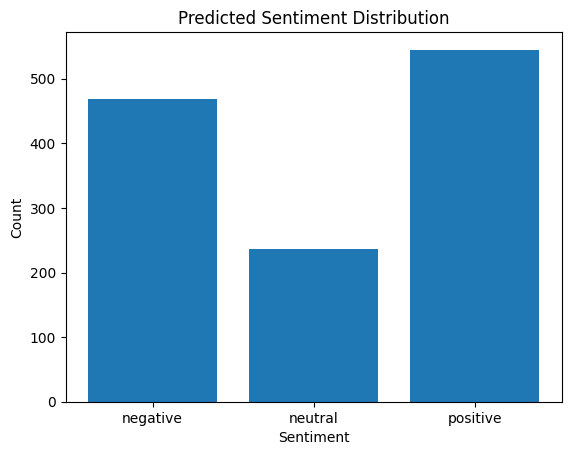

In [50]:
import matplotlib.pyplot as plt

sentiment_counts = pd.Series(pred_labels).value_counts().sort_index()

plt.figure()
plt.bar(class_names, sentiment_counts)
plt.title("Predicted Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Confidence Distribution

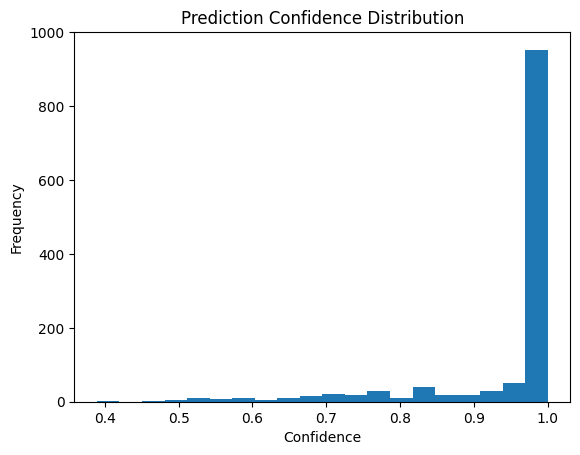

In [51]:
max_probs = [max(p) for p in probs]

plt.figure()
plt.hist(max_probs, bins=20)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()

# Confusion Matrix

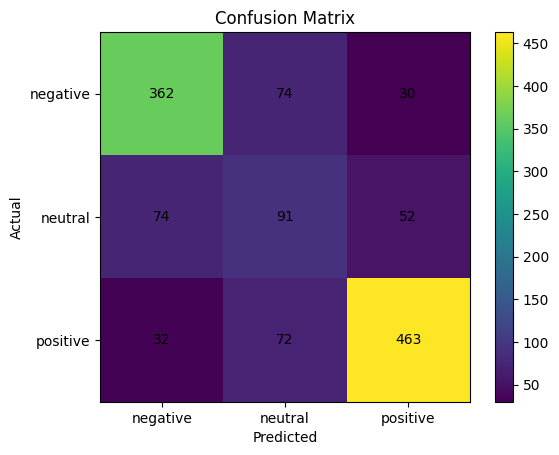

In [52]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(true_labels, pred_labels)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(3), class_names)
plt.yticks(range(3), class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()

# Count True Vs Predicted

In [54]:
import pandas as pd

results_df = pd.DataFrame({
    "True": true_labels,
    "Predicted": pred_labels
})

results_df["True_Label"] = results_df["True"].map({0:"Negative",1:"Neutral",2:"Positive"})
results_df["Pred_Label"] = results_df["Predicted"].map({0:"Negative",1:"Neutral",2:"Positive"})

count_table = pd.crosstab(
    results_df["True_Label"],
    results_df["Pred_Label"]
)

print(count_table)

Pred_Label  Negative  Neutral  Positive
True_Label                             
Negative         362       74        30
Neutral           74       91        52
Positive          32       72       463


# Total Counts

In [55]:
true_counts = results_df["True_Label"].value_counts().sort_index()
pred_counts = results_df["Pred_Label"].value_counts().sort_index()

count_summary = pd.DataFrame({
    "True_Count": true_counts,
    "Predicted_Count": pred_counts
})

print(count_summary)

          True_Count  Predicted_Count
Negative         466              468
Neutral          217              237
Positive         567              545


# Bar Chart — True Vs Predicted

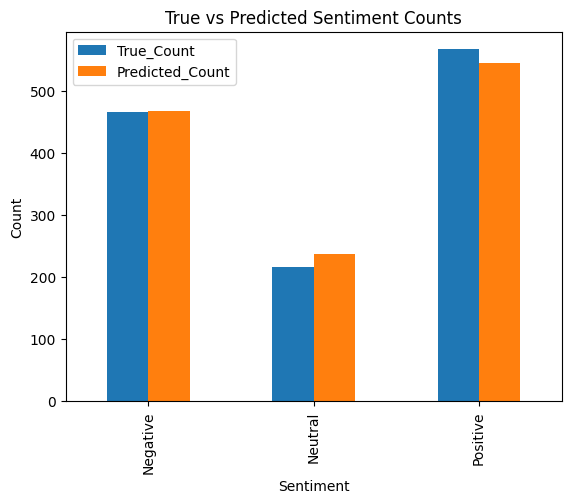

In [56]:
import matplotlib.pyplot as plt

count_summary.plot(kind="bar")
plt.title("True vs Predicted Sentiment Counts")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Stacked Bar (Error Distribution)

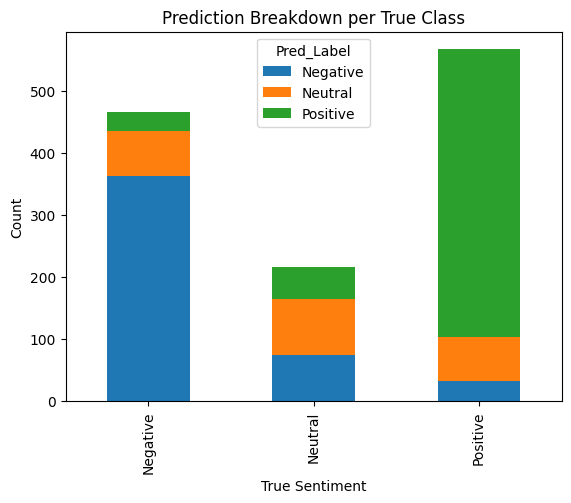

In [57]:
count_table.plot(kind="bar", stacked=True)
plt.title("Prediction Breakdown per True Class")
plt.xlabel("True Sentiment")
plt.ylabel("Count")
plt.show()